In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import pickle
import cv2

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

from data_preparation import ExternalDataPreparation
from main_v2 import MyPipeline
from evaluation import PipelineEvaluation

### Define path to folders 

In [2]:
# get current working directory 
cwd = os.getcwd()

### define paths to folder/files 

# external data 
vehiclepath = os.path.join(cwd, "external_data", "vehicles")
nonvehiclepath = os.path.join(cwd, "external_data", "non-vehicles")

# project data
train_folder = os.path.join(cwd, "train", "train")
label_file = os.path.join(cwd, "train", "train.csv")
test_folder = os.path.join(cwd, "test", "test")

# saved model 
model_pkl = os.path.join(cwd, "svm_classifier.pkl")

### Define parameters

In [28]:
# retrain classifier or not 
retrain_model = False  # if true retrain model and takes some time

# sliding window parameters 
step_size = 25
width = 200
height = 150

# limit nb of images used to compute Sorensen-Dice coeff 
limit = 50

### Create a classifier 

I want to train a classifier able to detect vehicles on images. To train an SVM model, I have found data on kaggle containing images with vehicles (labelled as positive) and images without vehicles (labelled as negative). 

The first step is to prepare data for training SVM model. Data preparation consists in extracting hog features using ExternaDataPreparation class.

In [29]:
# define datapreparator
preparator = ExternalDataPreparation(
    vehiclepath=vehiclepath, 
    nonvehiclepath=nonvehiclepath
)

Using this class, we can compute features for external data: 

In [30]:
if retrain_model: 
    X, y = preparator.prepare_features()

Using these features, we are know able to train an SVM classifier. Note that the classifier should be able to return a probability that will be used later to create bounding boxes. Higher is the probability of being a vehicle, the more chance there is to be in a bounding box later. 

In [31]:
if retrain_model:
    # separate train and test sets 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

    # define model
    model = SVC(probability=True)

    # trainf model
    model.fit(X_train, y_train)
    print('training done')

else:
    with open(model_pkl, 'rb') as file:
        model = pickle.load(file)

As our SVM model is now trained, we want to evaluate it in order to have an idea of the performance. The dataset used to train the model is balanced. Then, accuracy seems to be a good metric for evaluating the model. 

In [32]:
if retrain_model:
    # get predictions of the model on test set 
    y_pred = model.predict(X_test)

    # compute metrics 
    accuracy = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)

    # print metrics
    print(f"Accuracy: {round(accuracy, 2)}")
    print(f"F1-score: {round(f1, 2)}")

### Construct whole pipeline 

Now, we have a trained classifier that works pretty well. However, we are still far from a complete pipeline. 

Strategy to create bounding boxes is to use a "sliding window" approach (see sliding_window.py file). Thus, each image is divided into smaller window. Features will be extracted from each of these window to finally label (= proba there is a vehicle on the window) using our new trained classifier. 

Finally, each pixel is the sum of the proba of windows to wich it belongs. Using a threshold, it helps creating a mask and finally create bounding boxes from it.  

In [33]:
# define pipeline 
pipeline = MyPipeline(
    features_extractor=preparator.create_hog_features, 
    model=model, 
    step_size=step_size, 
    width=width, 
    height=height
)

Now as the pipeline is trained, we can visualize some examples: 

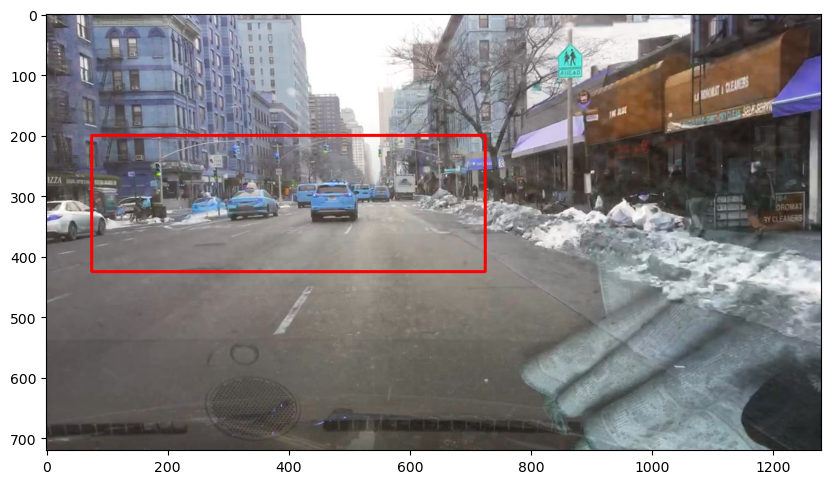

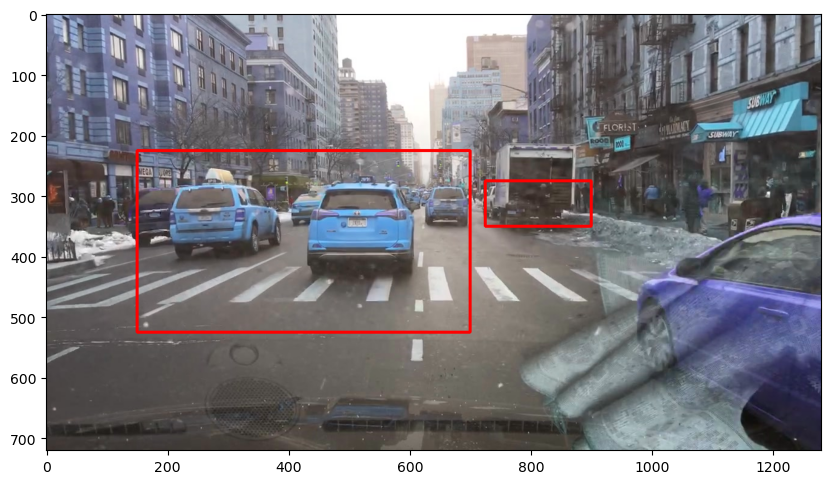

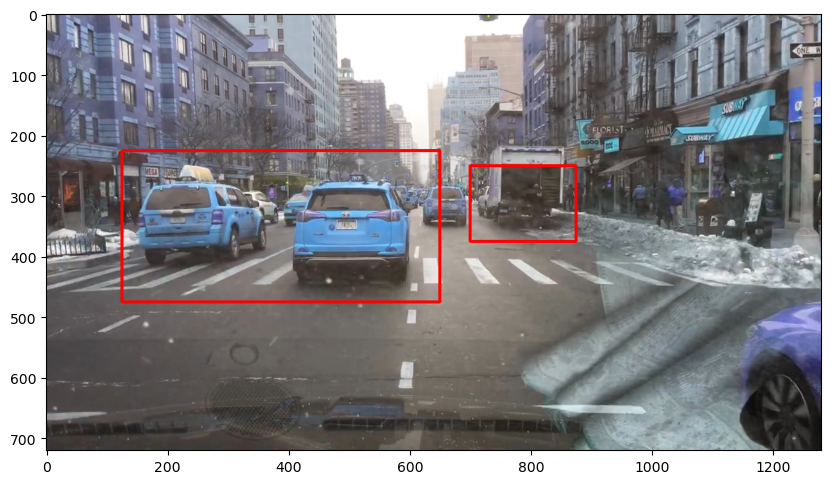

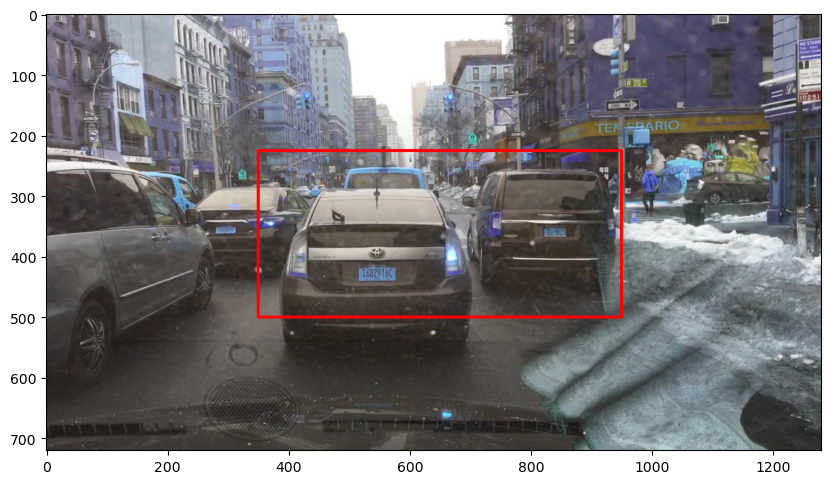

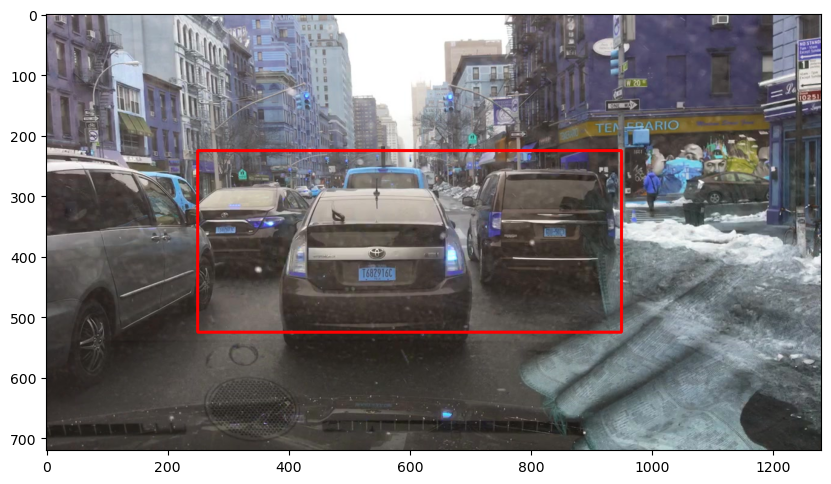

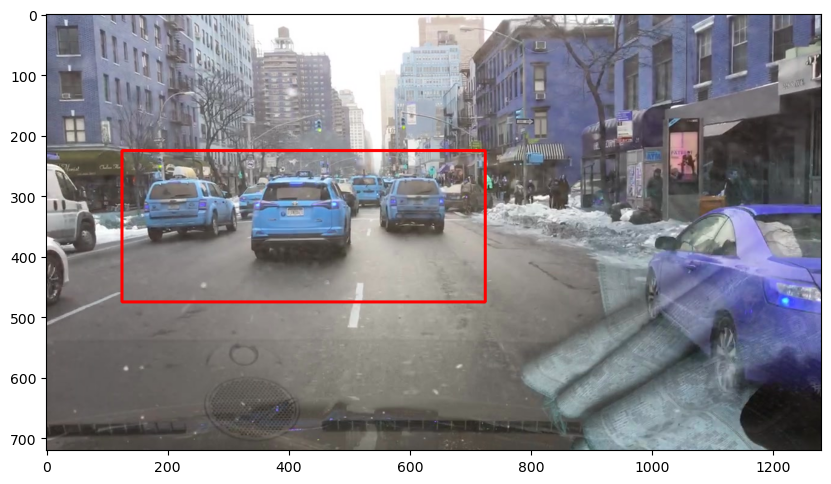

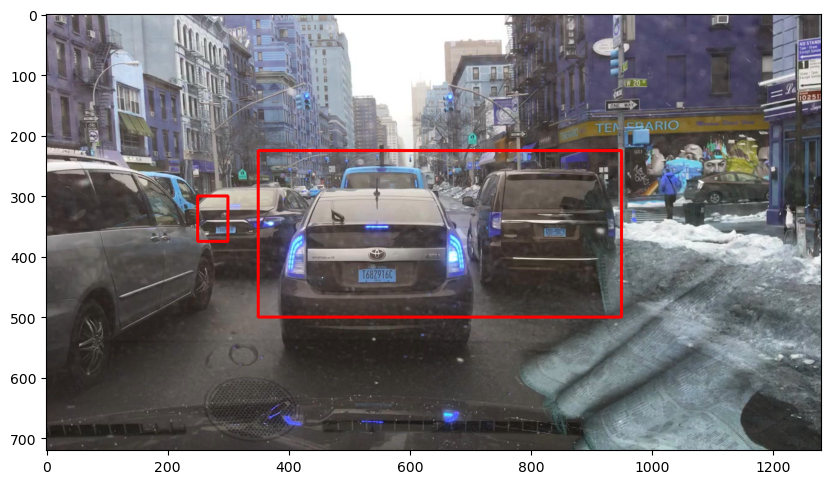

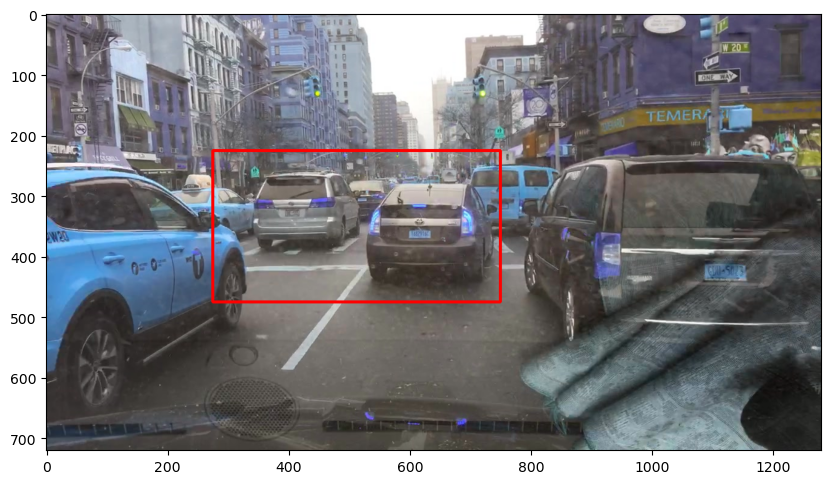

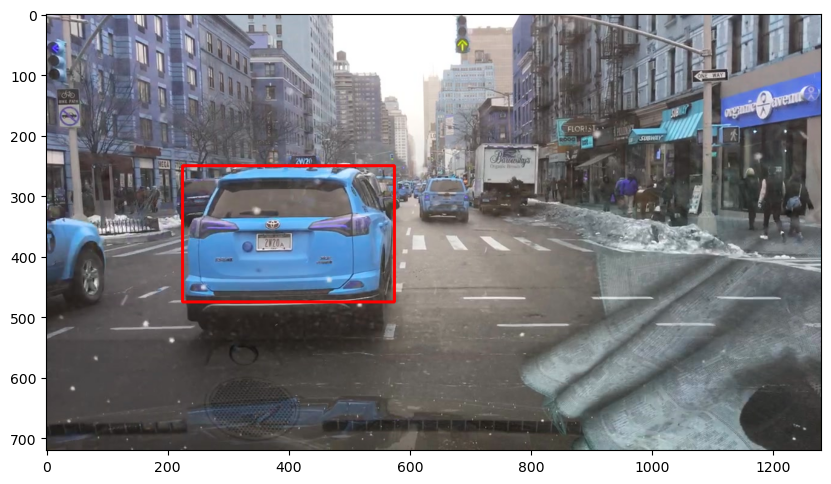

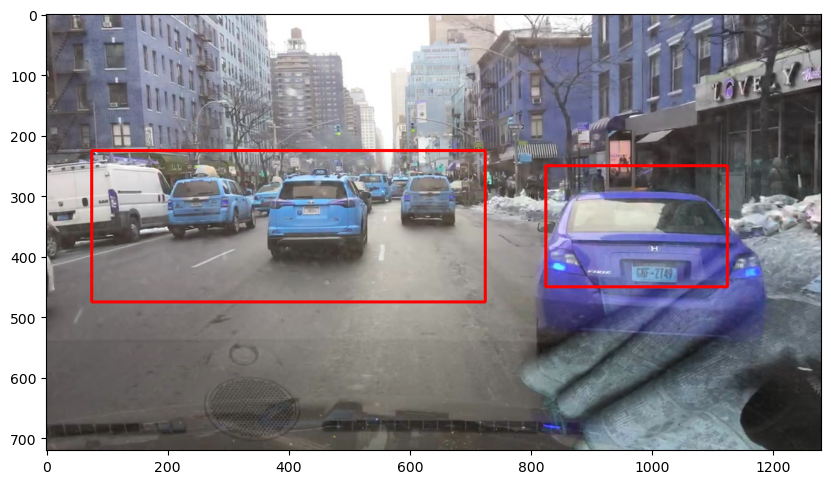

In [34]:
# nb of images to visualize 
nb_images = 10

# choose random images in test set 
test_images = os.listdir(test_folder)
nb = np.random.randint(0, len(test_images), size=nb_images)

for n in nb:
    img_path = os.path.join(test_folder, test_images[n])
    pipeline.plot(img_path=img_path)

As we can see on these examples, the model works pretty well. It seems that it is able to find vehicles on images. However, we have for now no idea about its possible performance in production (or on kaggle). 

So now, let's evaluate our model.

### Pipeline evaluation 

In [35]:
# define evaluation strategy 
evaluation = PipelineEvaluation(train_folder, label_file)

In [36]:
# compute coeff 
avg_dice_coeff = evaluation.compute_metric(pipeline.inference, limit=limit)
print("Sorensen-Dice coeff: ", avg_dice_coeff)

Sorensen-Dice coeff:  0.3855426827721697
